## BAO inverse distance ladder
I provide you with a series of power spectrum measurements, at effective redshifts $z_{\mathrm{zeff}}$ = 0.1 to 1.9.
In this session, you will:

1) measure the BAO isotropic parameter $\alpha(z_{\mathrm{eff}}) = \left[D_{V}(z_{\mathrm{eff}})/r_{\mathrm{drag}}\right] / \left[D_{V}^{\mathrm{fid}}(z_{\mathrm{eff}})/r_{\mathrm{drag}}^{\mathrm{fid}}\right]$ of each of the measurements

2) with these measurements, you will constrain $\Omega_{m}, \Omega_{k}$ (hence detect dark energy!)

3) provided a value of $r_{\mathrm{drag}}$ (in $\mathrm{Mpc}$), you will perform an "inverse distance ladder" analysis: fit all the $\alpha(z_{\mathrm{eff}})$ by varying $H_{0}$ and $\Omega_{m}$

4) those finding the correct $\Omega_{m}$, $\Omega_{k}$ and $H_{0}$ (I know the truth, you don't!) win!

5) do you remember how to compute the correlation function? (last year's TD) What about the power spectrum? If any question, please ask!

### First, look at power spectrum measurements

At effective redshift 0.10 first k are [0.007493 0.016066], pk0 [43579.87204033 59574.23898799]
At effective redshift 0.30 first k are [0.007493 0.016066], pk0 [58159.9772374  64155.31692157]
At effective redshift 0.50 first k are [0.007493 0.016066], pk0 [28531.12726767 56291.46363898]
At effective redshift 0.70 first k are [0.007493 0.016066], pk0 [36963.90375436 63273.70445805]
At effective redshift 0.90 first k are [0.007493 0.016066], pk0 [50049.25596832 61289.87142888]
At effective redshift 1.10 first k are [0.007493 0.016066], pk0 [48863.32973323 53625.9455684 ]
At effective redshift 1.30 first k are [0.007493 0.016066], pk0 [34614.37361749 54242.10958604]
At effective redshift 1.50 first k are [0.007493 0.016066], pk0 [56665.8185425  64685.36388254]
At effective redshift 1.70 first k are [0.007493 0.016066], pk0 [46548.2941793 54362.160772 ]
At effective redshift 1.90 first k are [0.007493 0.016066], pk0 [41706.41774374 50776.07570434]


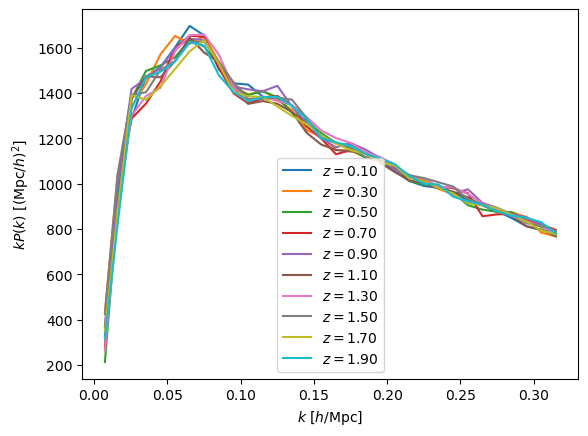

Attributes {'space': 'power', 'tracer': 'LRGpCMASS', 'zeff': 1.9000000000000001, 'recon': False, 'ells': [0, 2, 4]}


In [1]:
import numpy as np
from matplotlib import pyplot as plt

from environment import Measurement, list_path_sim_measurement # contains paths

list_path = list_path_sim_measurement()
list_data = []

for path in list_path:
    m = Measurement.load(path)
    print('At effective redshift {:.2f} first k are {}, pk0 {}'.format(m.attrs['zeff'],m.x[:2],m.y[0,:2]))
    plt.plot(m.x,m.x*m.y[0],label='$z = {:.2f}$'.format(m.attrs['zeff']))
    list_data.append(m)

plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()
# m is an instance of Measurement
# k (wavenumber) array is m.x
# pk (power spectrum) is m.y
# m.y is of shape (1,len(m.x)): the first Legendre multipole (monopole).
print('Attributes',m.attrs)

### Code isotropic BAO power spectrum model

The idea is to measure *only* the position of the BAO, marginalizing over the shape of the power spectrum, to remain robust to distortions due to observational systematics.
For this we decompose the fiducial power spectrum into *wiggle* and *no-wiggle* parts. We will allow the *wiggle* part to move, keeping the *no-wiggle* part fixed, adding polynomial in $k$ to adjust the shape of the data power spectrum.

In [16]:
# first get a linear power spectrum in $(\mathrm{Mpc}/h)^{3}$, at the redshifts of interest
# use e.g. classy, camb... (also cosmoprimo, personal package: https://github.com/adematti/cosmoprimo)
# fiducial cosmological parameters (used to the power spectrum above) is:
# dict(Omega_m=0.31,Omega_b=0.022/0.676**2,h=0.676,sigma8=0.8,n_s=0.97)
from nbodykit.lab import cosmology
Omega_b = 0.022/0.676**2
Omega_cdm = 0.31 - Omega_b
cosmo_fid = cosmology.Cosmology(Omega_cdm=Omega_cdm,Omega_b=Omega_b,h=0.676,sigma8=0.8,n_s=0.97)
klin = np.logspace(-4,np.log10(5),2000)
pklin = cosmology.LinearPower(cosmo_fid,redshift=0.,transfer='CLASS')(klin) # D^{2}(z) will be marginalized by B^2
np.savetxt('pklin.txt',np.array([klin,pklin]).T)

In [3]:
# Then you need a smooth power spectrum, matching the linear power spectrum but without BAO wiggles.
# Several options:
# 1) use Eisenstein & Hu 1998 formula, complemented with polynomials to correctly adjust the linear power spectrum
# 2) fit the linear power spectrum in log/log with a polynomial (Hinton2017)
# np.polynomial.polynomial.Polynomial.fit(logk,logpk,degree=13,w=w)
# 3) use cosmoprimo PowerSpectrumBAOFilter(pk_interpolator, engine='wallish2018')
# Plot wiggles = linear power spectrum / no-wiggle power spectrum
logk = np.log(klin)
logpk = np.log(pklin)
maxk = logk[pklin.argmax()]
gauss = np.exp(-0.5 * ((logk - maxk) / 1.)**2)
w = np.ones_like(klin) - 0.5 * gauss
series = np.polynomial.polynomial.Polynomial.fit(logk,logpk,deg=13,w=w)
pknow = np.exp(series(logk))

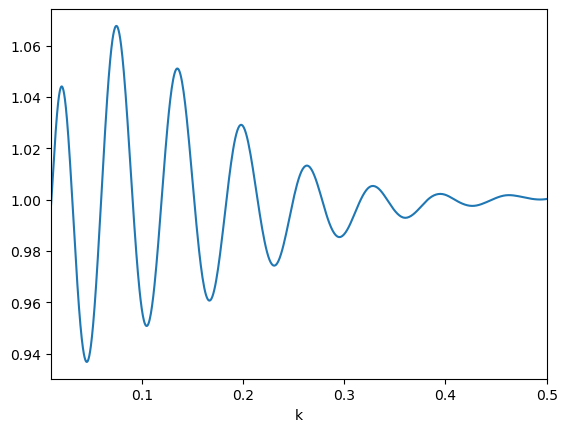

In [4]:
wiggles = pklin/pknow
plt.plot(klin,wiggles)
plt.xlim(1e-2,0.5)
plt.xlabel('k')
plt.show()

Model equation is: $P(k,\alpha) = B^{2} [P_{\mathrm{nw}}(k) + \sum_{i=0}^{2} A_{i} k^{i}] \lbrace 1 + [\mathcal{O}(k/\alpha) - 1] e^{- \frac{1}{2} \Sigma_{\mathrm{nl}}^{2}k^{2}} \rbrace$  
$P_{\mathrm{nw}}$ is the no-wiggle power spectrum.  
$\mathcal{O}(k) = P_{\mathrm{lin}}(k)/P_{\mathrm{nw}}(k)$ are the wiggles.  
Free parameters are: $\alpha, B, A_{i}$, parameter of cosmological interest in $\alpha$.  
Choose for the non-linear damping of BAO wiggles $\Sigma_{\mathrm{nl}} = 6.7\;\mathrm{Mpc/h}$.

In [5]:
sigmanl = 6.7
def pk_iso(k, alpha, B, A0, A1, A2, A3=0):
    """Code here power spectrum model"""
    pknow_ = np.interp(k,klin,pknow)
    poly = A0 + A1*k + A2*k**2 + A3/k
    damped_wiggles = 1 + (np.interp(k/alpha,klin,wiggles) - 1)*np.exp(-1./2.*sigmanl**2*k**2)
    return B**2*(pknow_ + poly)*damped_wiggles

### Now model fitting
Repeat, for each redshift z:  
Build $\chi^{2} = (\mathrm{data} - \mathrm{model})^T C^{-1} (\mathrm{data} - \mathrm{model})$  
For a rapid check, minimize chi2 for example with scipy.optimize.minimize

Reduced chi2 is 24.5372/(32 - 5) = 0.9088


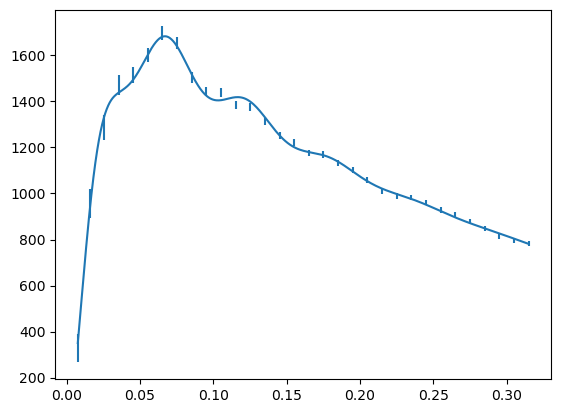

Reduced chi2 is 46.1346/(32 - 5) = 1.7087


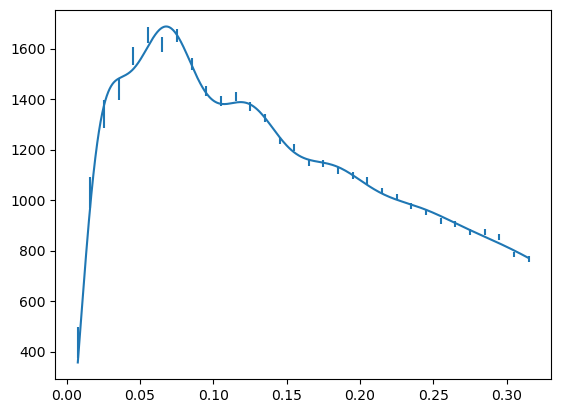

Reduced chi2 is 38.1661/(32 - 5) = 1.4136


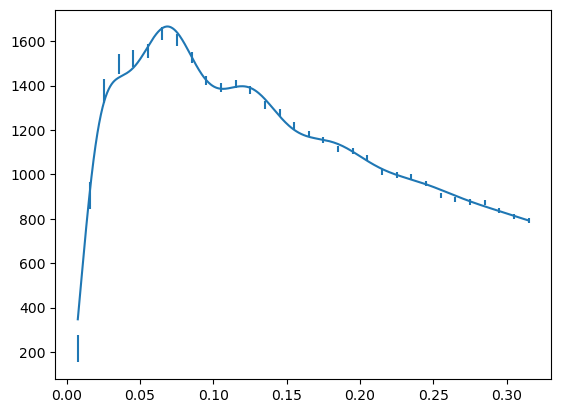

Reduced chi2 is 60.2450/(32 - 5) = 2.2313


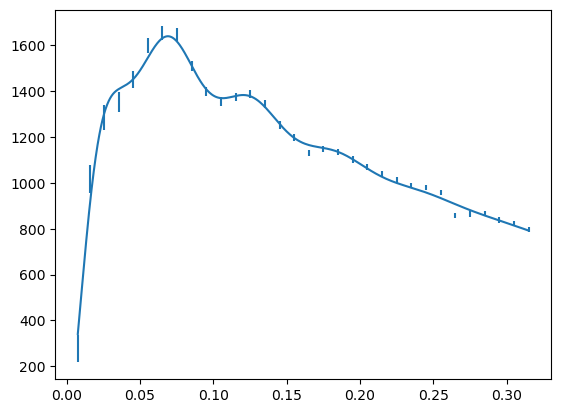

Reduced chi2 is 29.6595/(32 - 5) = 1.0985


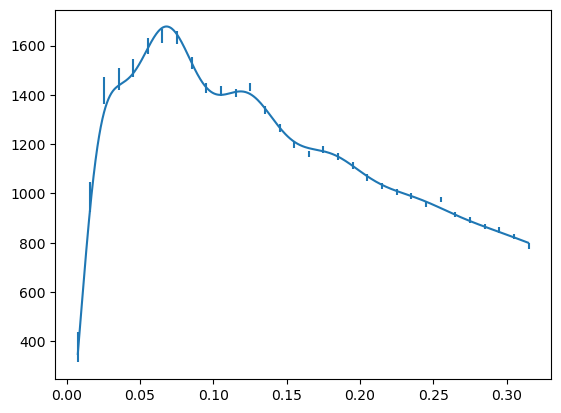

Reduced chi2 is 19.3925/(32 - 5) = 0.7182


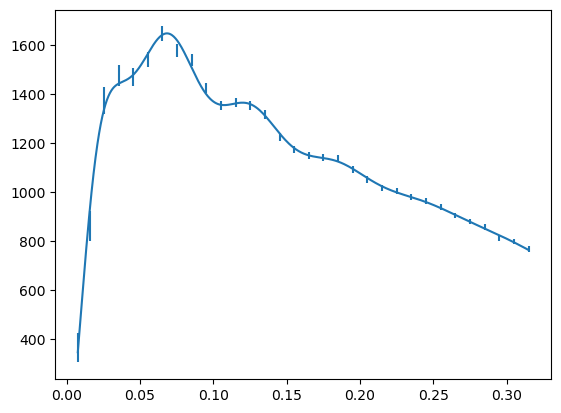

Reduced chi2 is 24.3465/(32 - 5) = 0.9017


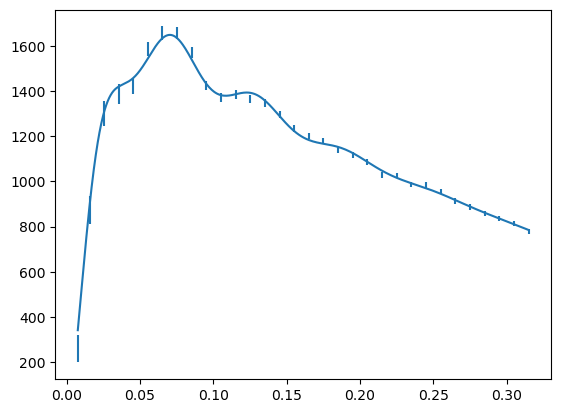

Reduced chi2 is 30.2531/(32 - 5) = 1.1205


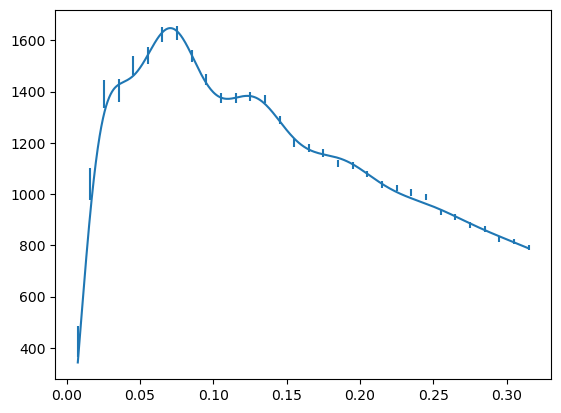

Reduced chi2 is 31.6967/(32 - 5) = 1.1740


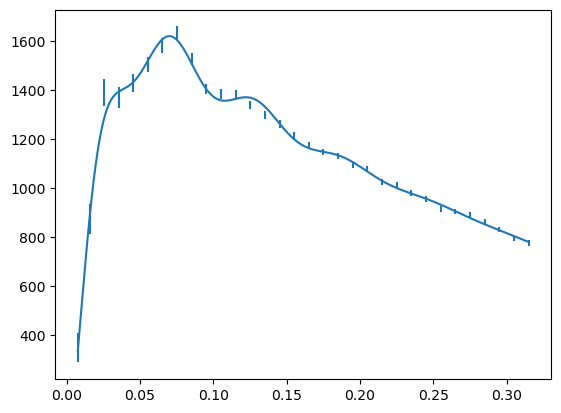

Reduced chi2 is 29.5715/(32 - 5) = 1.0952


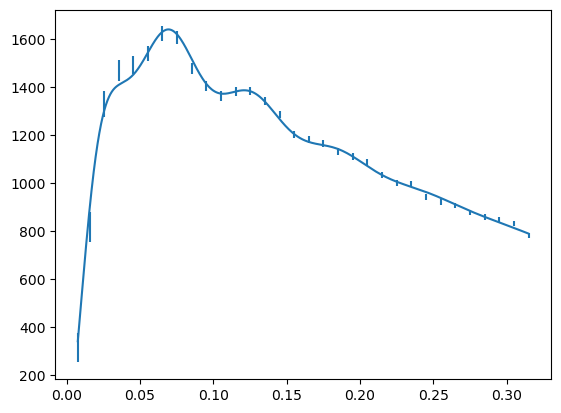

In [6]:
from scipy import optimize

nbb = 3
init = [1.,2.] + [0.]*nbb
bounds = [(0.88,1.12),(1.,5.)] + [(-5e4,5e4)]*nbb

for m in list_data:
    covariance = m.cov
    invcovariance = np.linalg.inv(covariance)
    k = m.x
    data = m.y[0]
    
    def chi2(args):
        model = pk_iso(k,*args)
        diff = data - model
        toret = diff.T.dot(invcovariance).dot(diff)
        return toret
    
    result = optimize.minimize(chi2,init,method='SLSQP',bounds=bounds)
    args = result.x
    minchi2 = chi2(args)
    msg = 'Reduced chi2 is {:.4f}/({:d} - {:d}) = {:.4f}'.format(minchi2,len(k),len(args),minchi2/(len(k) - len(args)))
    print(msg)
    kplt = klin[(klin > k[0]) & (klin < k[-1])]
    """Make plot of data, model, error bars"""
    plt.errorbar(k,k*data,k*np.diag(covariance)**0.5,linestyle='none',color='C0')
    plt.plot(kplt,kplt*pk_iso(kplt,*args),label='model',color='C0')
    plt.show()

We want an error on our alpha measurement. Either:
- likelihood profiling: repeat the above for alpha values in e.g. [0.9,1.1], and take errors at $\chi_{\mathrm{min}}^{2} + 1$
- likelihood sampling: use sampler, e.g. https://github.com/minaskar/zeus

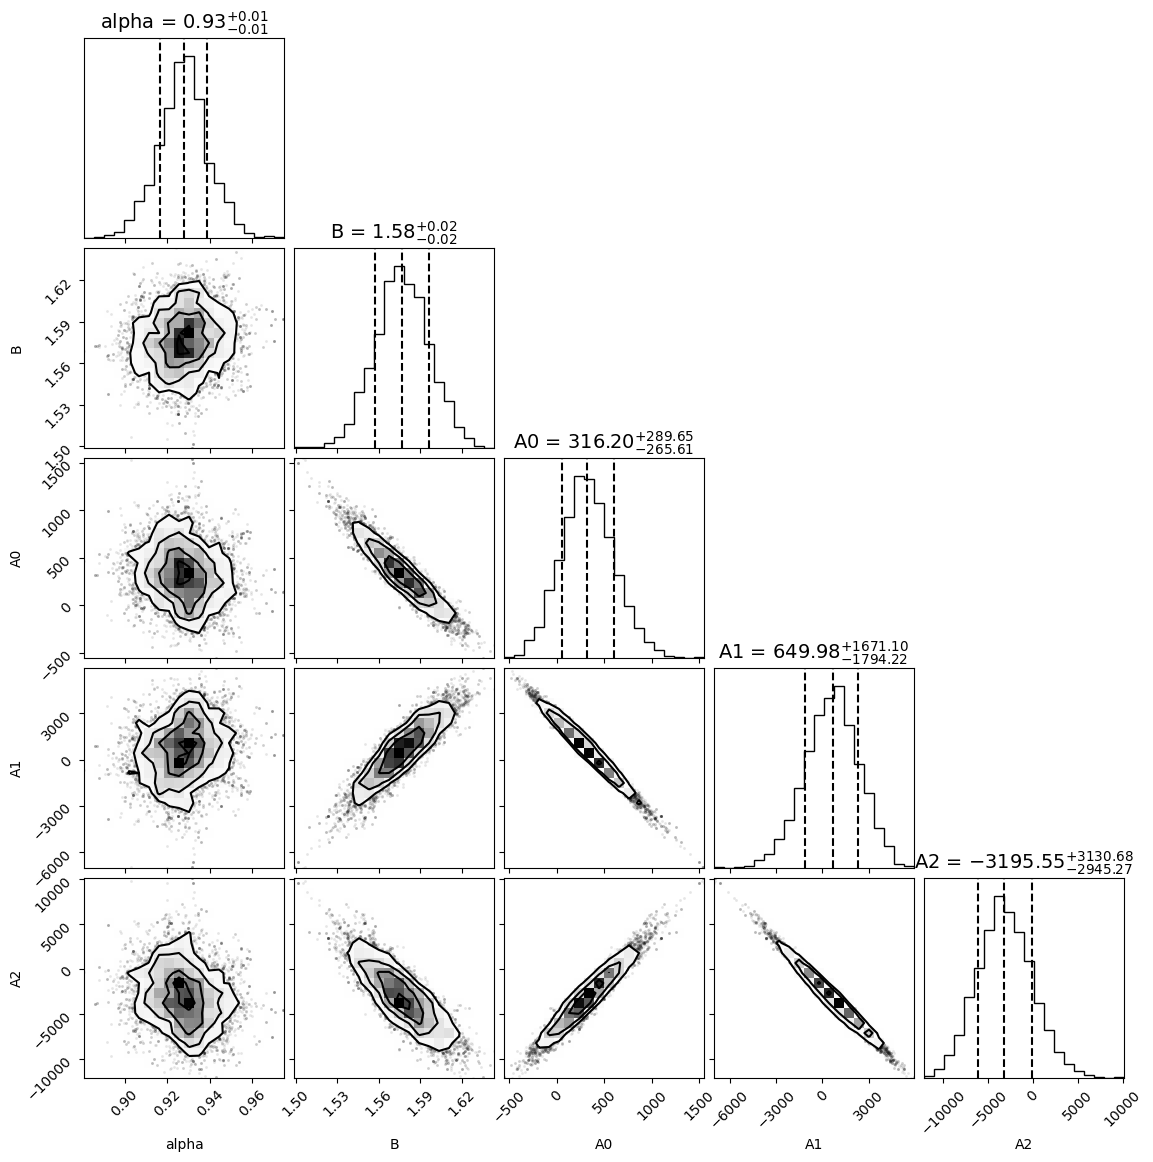

/local/home/adematti/anaconda3/envs/cosmopipe-dev/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


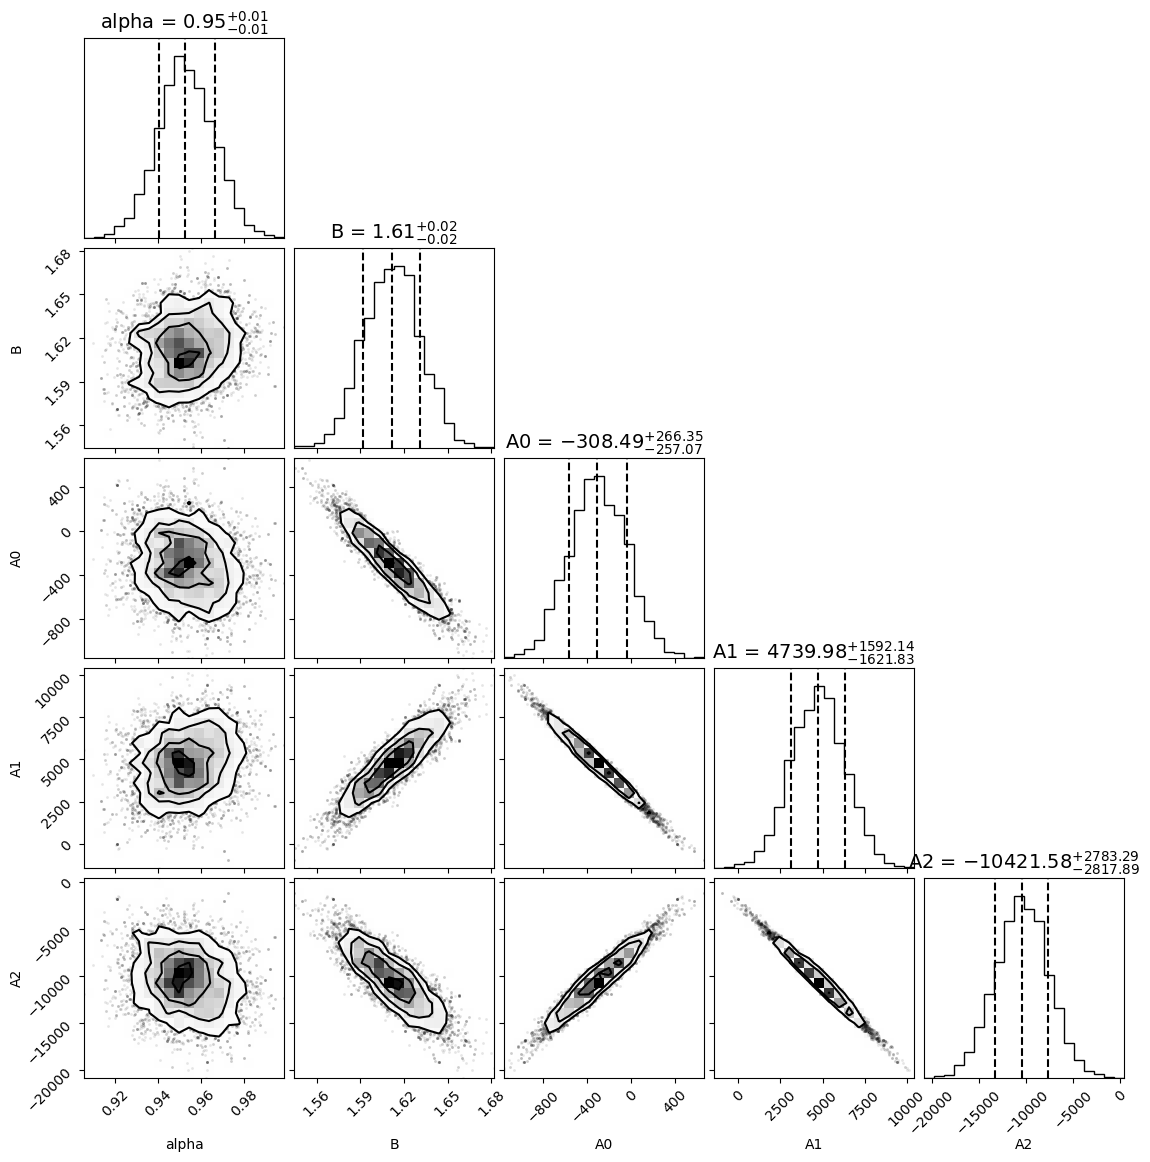

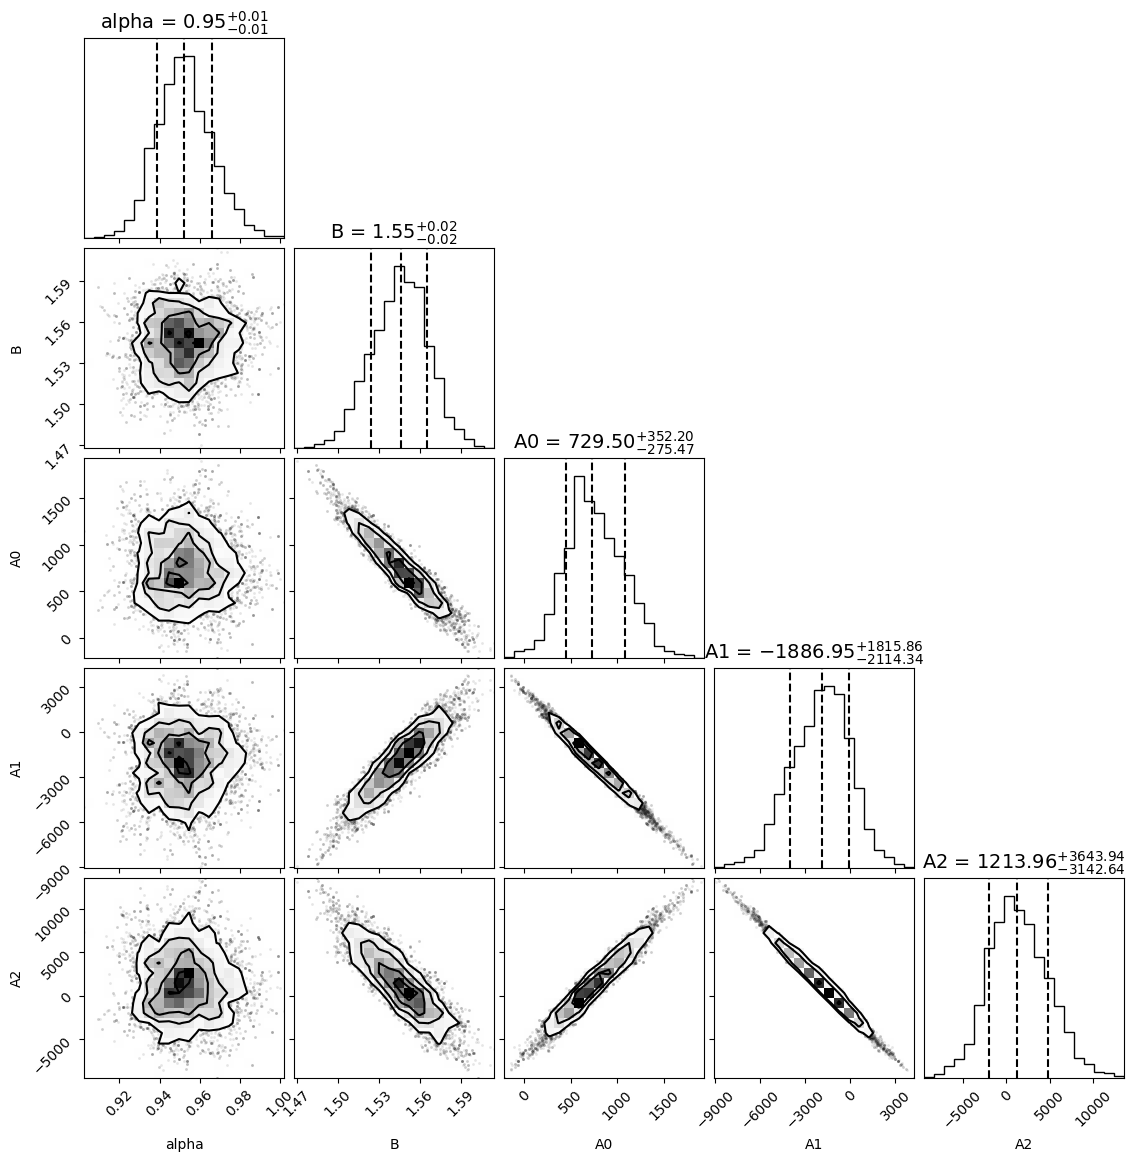

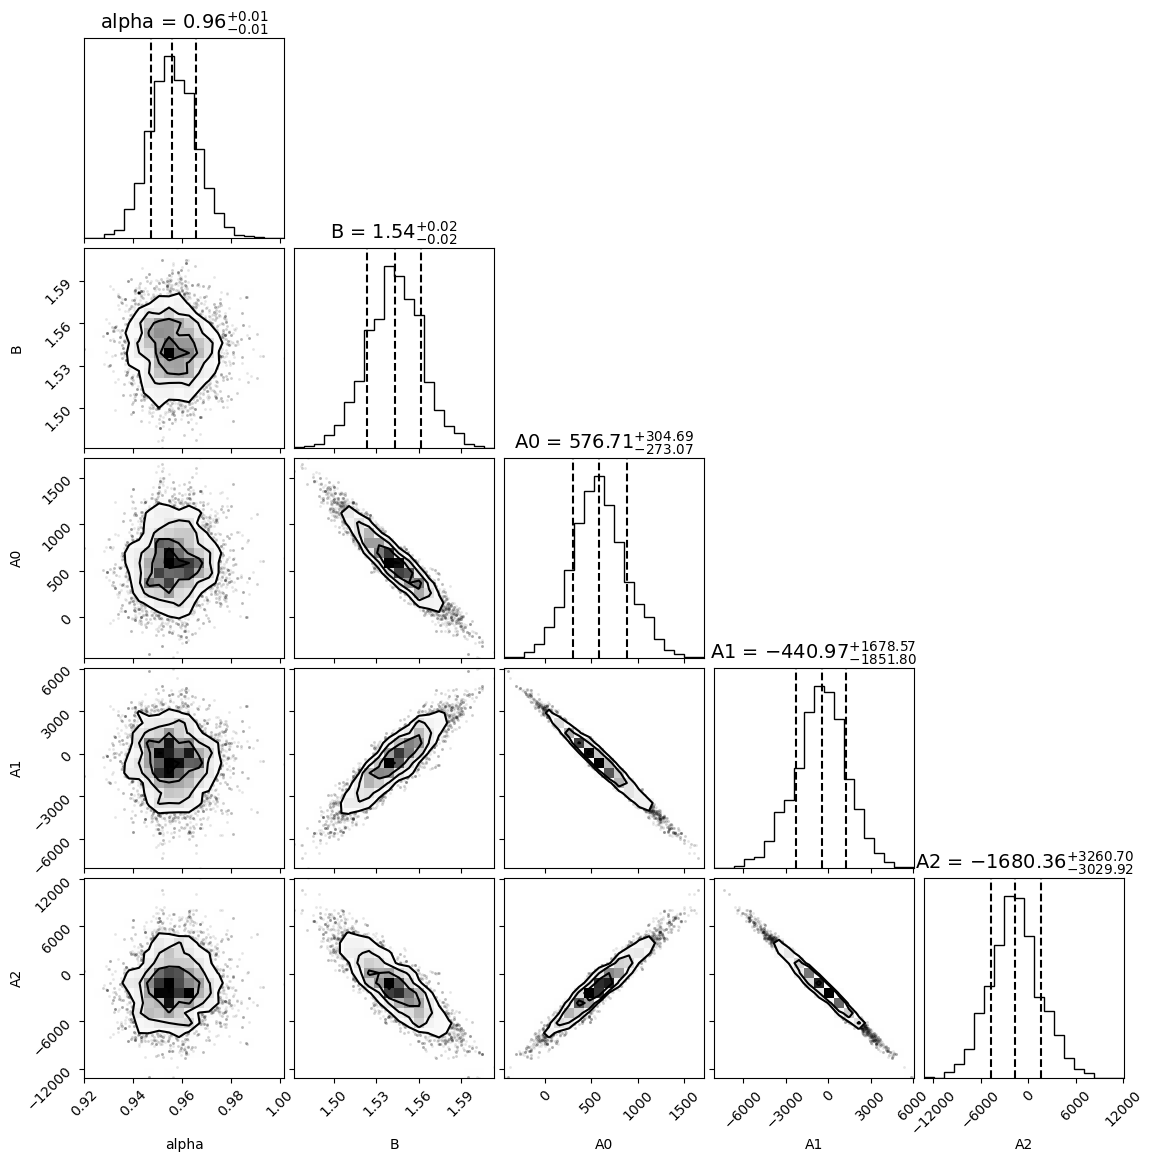

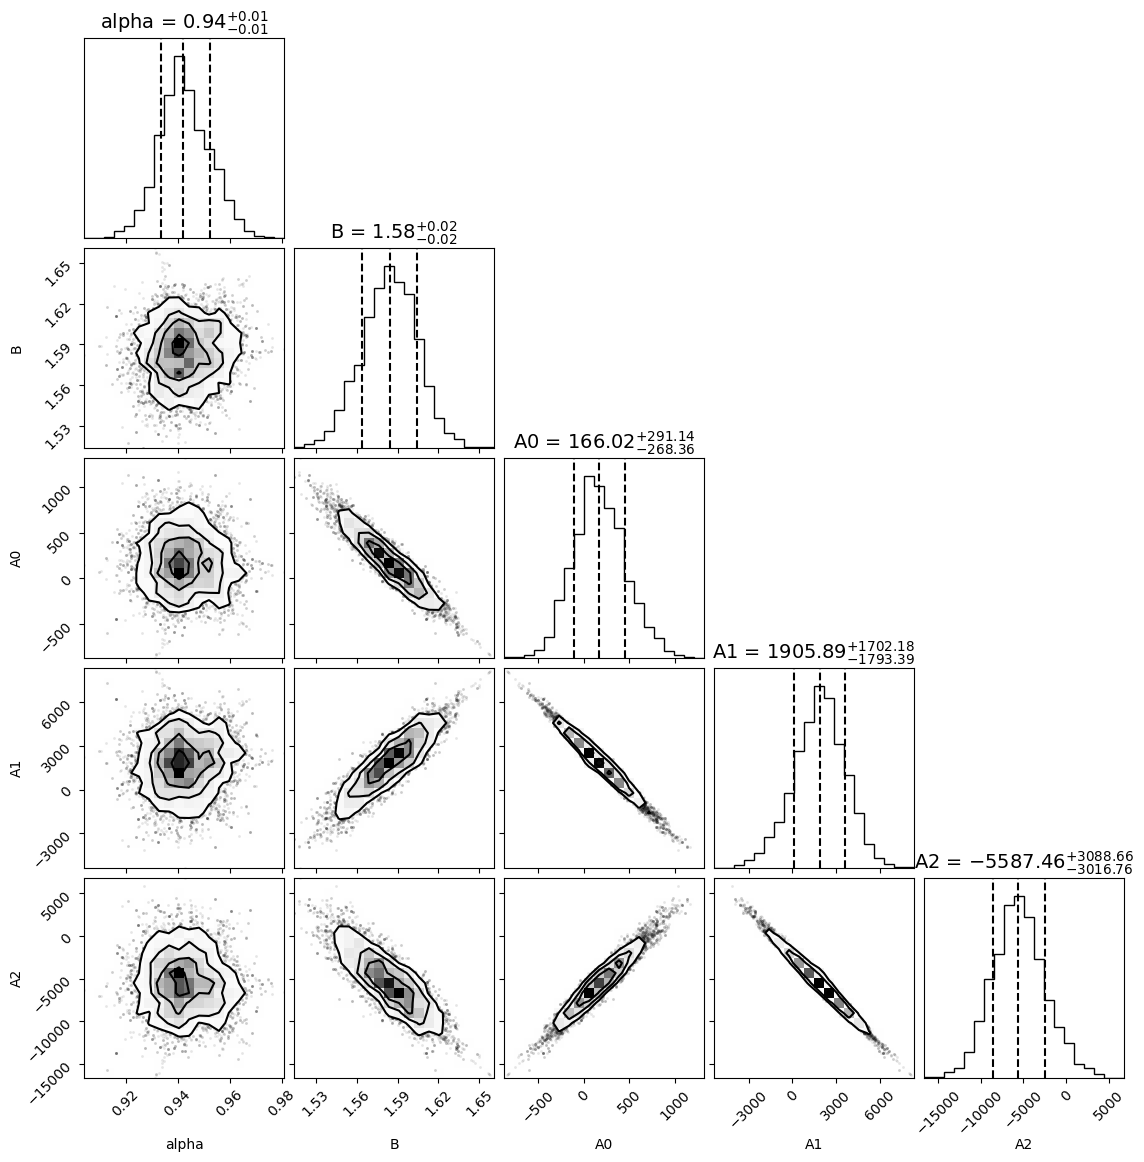

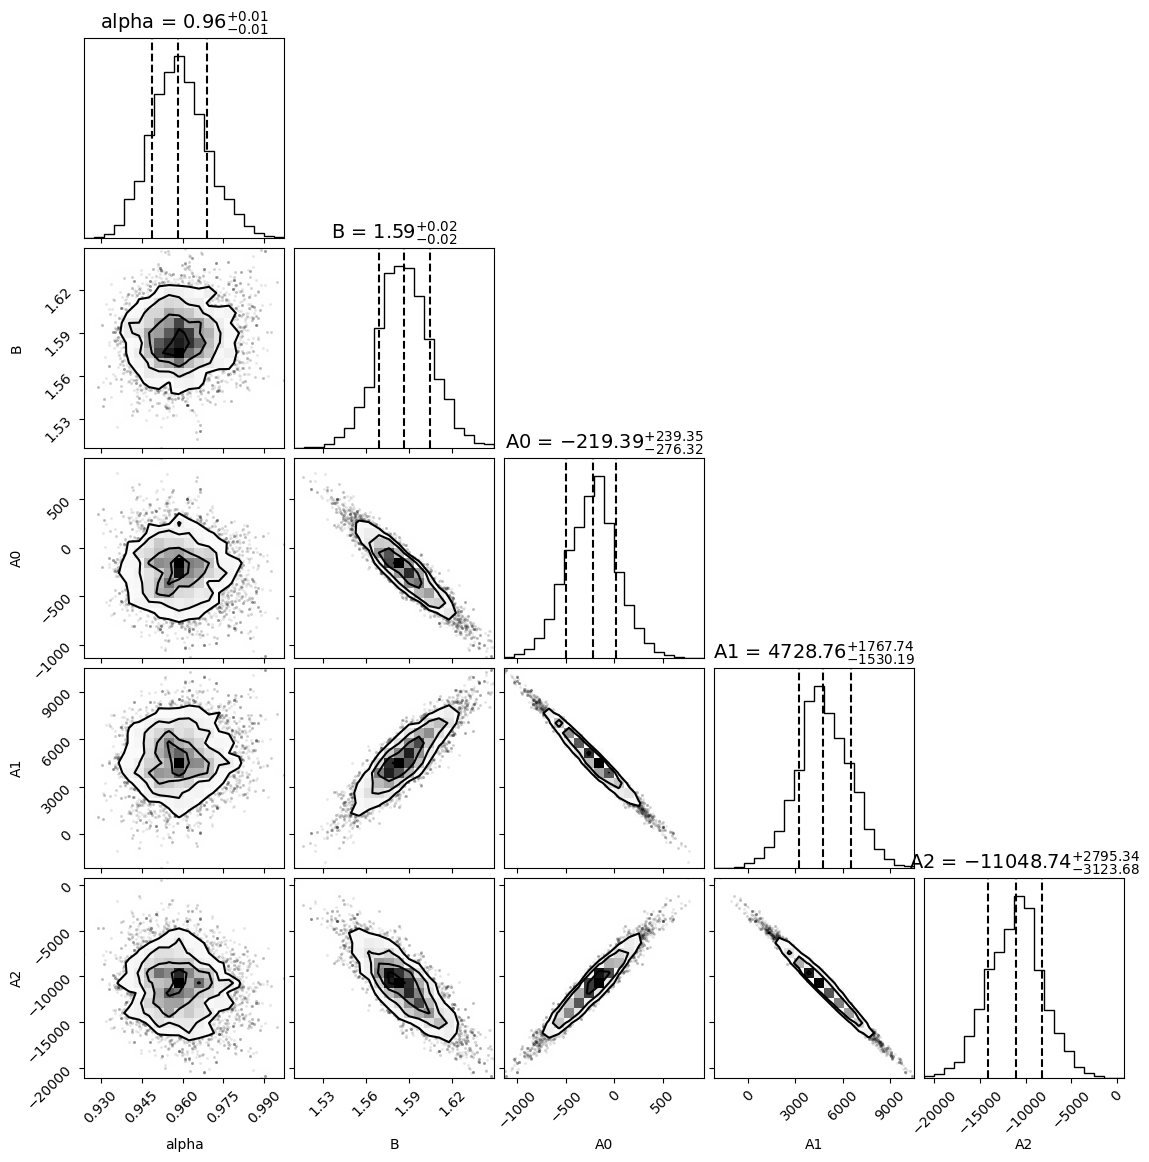

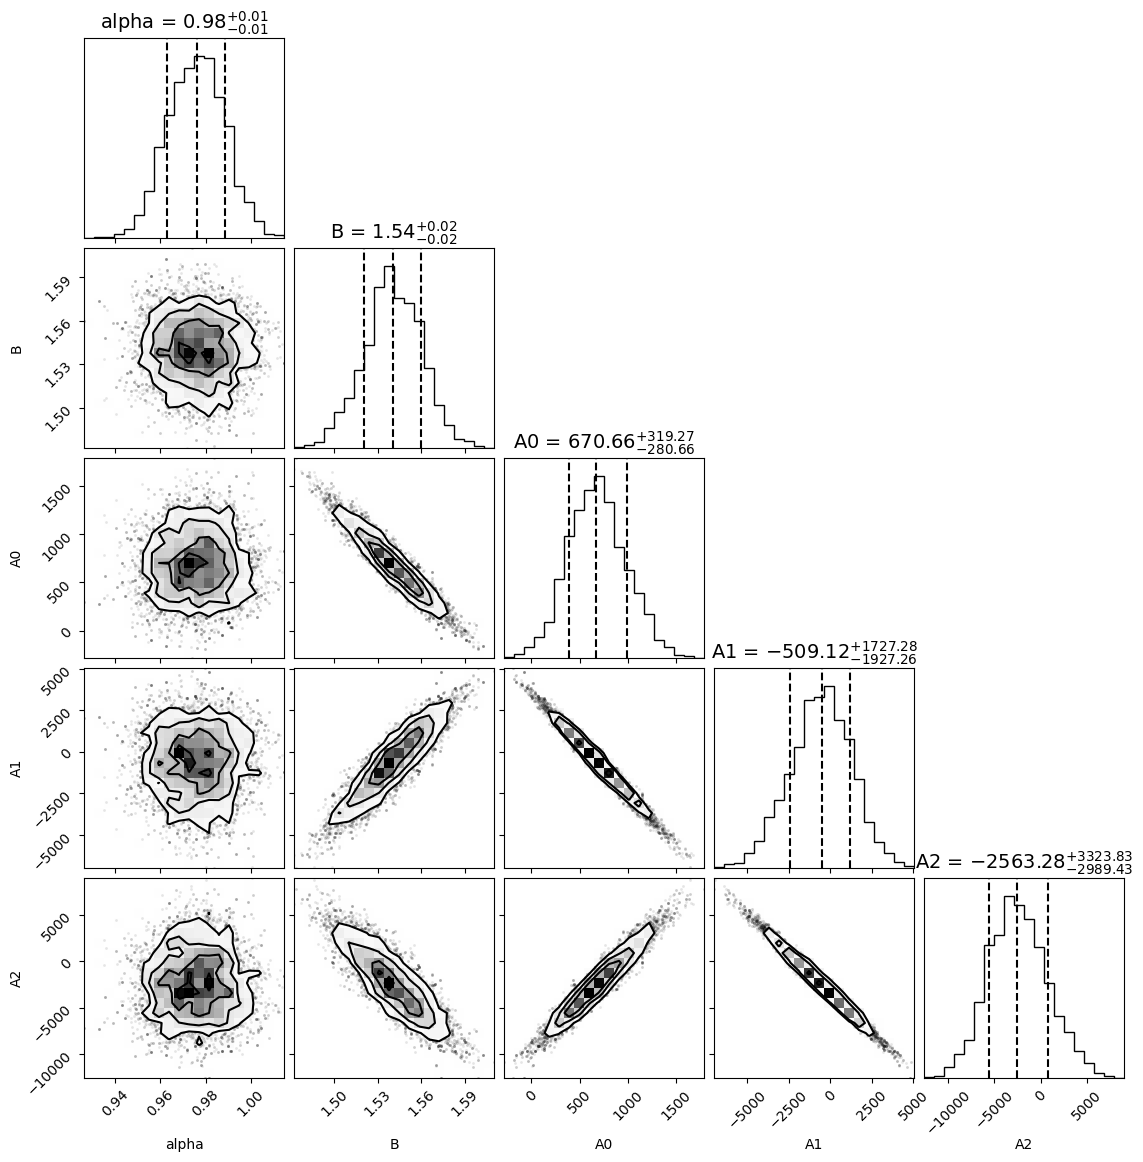

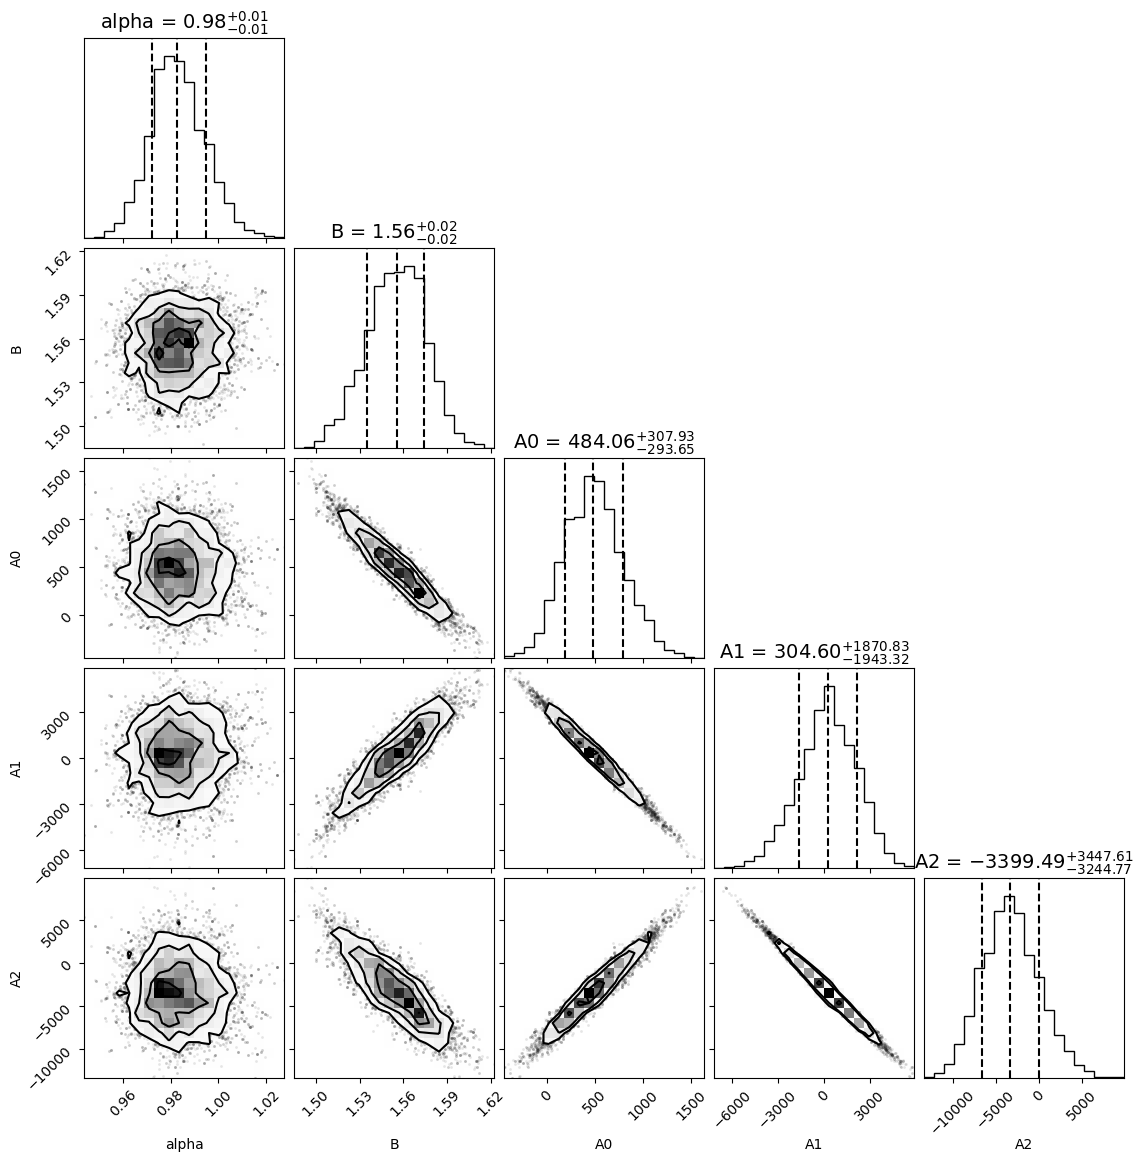

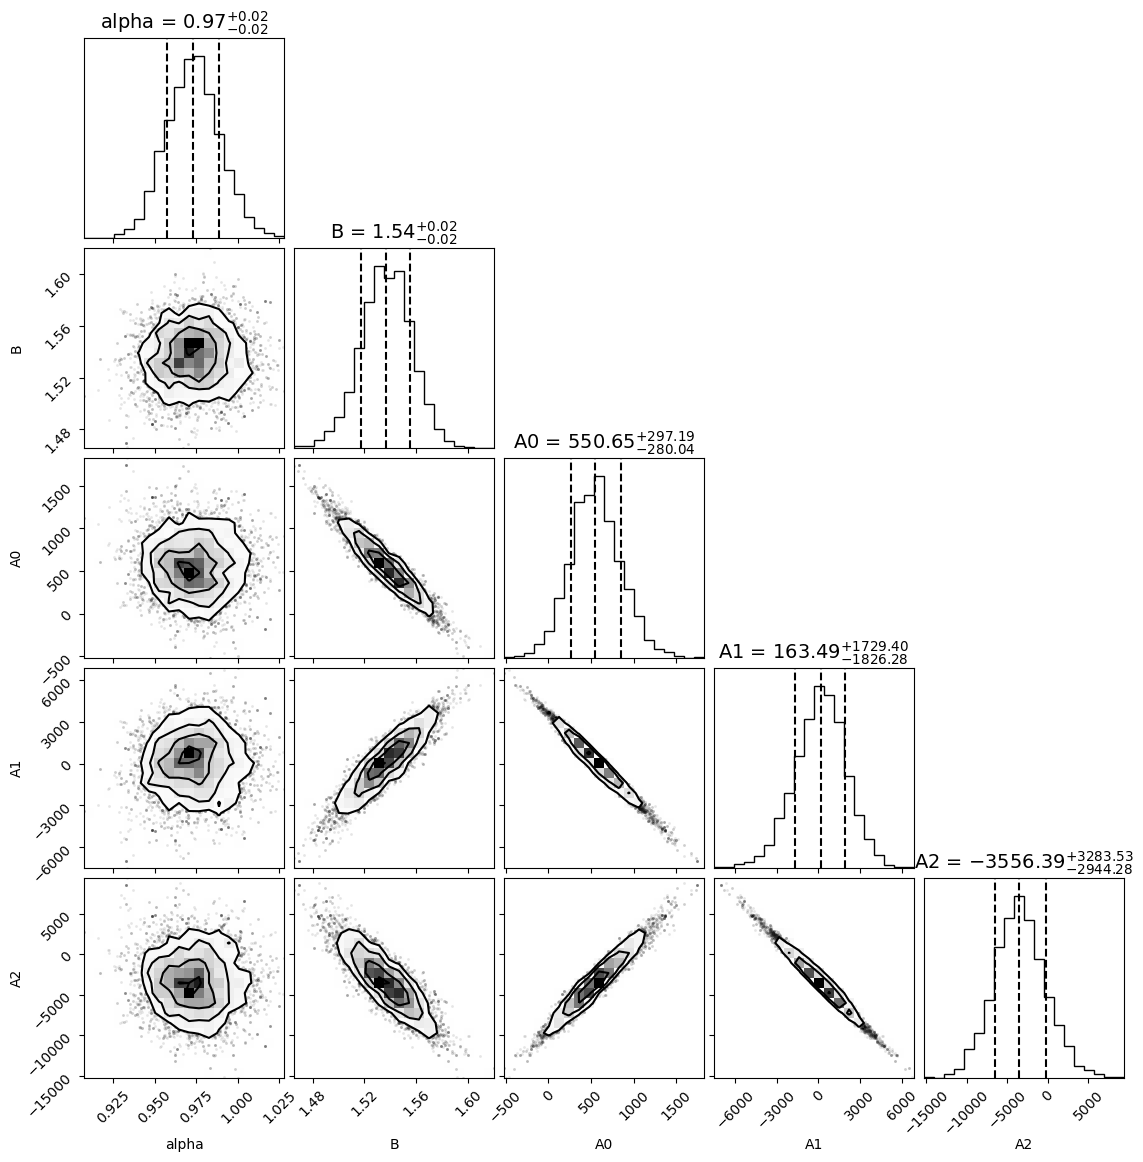

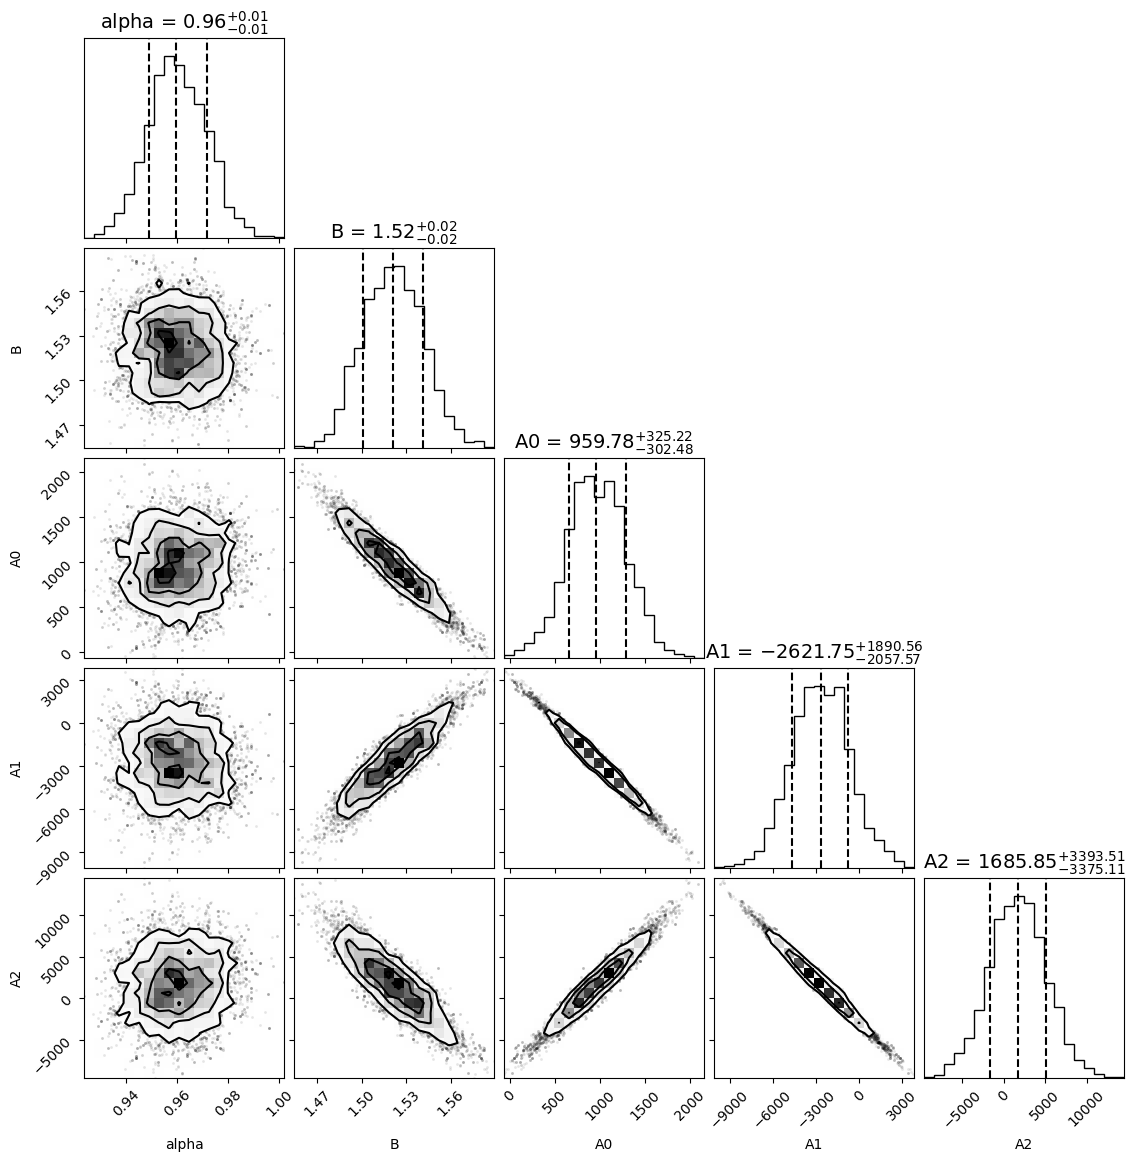

In [7]:
import emcee
import corner

nsteps = 4000
ndim = len(bounds)
nwalkers = 2*ndim
list_mean = []
list_covariance = []

for m in list_data:

    covariance = m.cov
    invcovariance = np.linalg.inv(covariance)
    k = m.x
    data = m.y[0]
    
    def chi2(args):
        model = pk_iso(k,*args)
        diff = data - model
        toret = diff.T.dot(invcovariance).dot(diff)
        return toret
    
    def logprior(args):
        for x,b in zip(args,bounds):
            if not (x > b[0]) & (x < b[1]):
                return -np.inf
        return 0.
    
    def logposterior(args):
        tmp = logprior(args)
        if not np.isfinite(tmp): return tmp
        return -1./2.*chi2(args) + tmp
    
    sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
    start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
    sampler.run_mcmc(start,nsteps)
    samples = sampler.get_chain(flat=True)
    # Look at samples, remove burnin
    samples = samples[len(samples)*3//4:]
    # Take mean (or median) and covariance of samples
    mean = np.median(samples[:,0])
    covariance = np.cov(samples[:,0])
    list_mean.append(mean)
    list_covariance.append(covariance)
    labels = ['alpha','B'] + ['A{:d}'.format(i) for i in range(nbb)]
    fig = corner.corner(samples,labels=labels,quantiles=[0.16,0.5,0.84],show_titles=True,title_kwargs={'fontsize':14})
    plt.show()
    plt.close(fig)

### Expansion history
The measured $\alpha$ can be modelled through $\alpha_{\mathrm{theory}}(z) = \left[D_{V}(z_{\mathrm{eff}})/r_{\mathrm{drag}}\right] / \left[D_{V}^{\mathrm{fid}}(z_{\mathrm{eff}})/r_{\mathrm{drag}}^{\mathrm{fid}}\right]$. Why?  
$D_{V}(z) = z^{1/3} D_{M}(z)^{2/3} D_{H}(z)^{1/3}$ with $D_{M}(z)$ comoving transverse distance, $D_{H}(z) = c/H(z)$ "Hubble distance"  
Code up $D_{M}(z)$, $D_{H}(z)$ as a function of $\Omega_{m}$ and $\Omega_{k}$ (faster than creating a new cosmology at each MCMC step).  
Build the $\chi^{2}$ of the previously measured $\alpha$, using $\alpha_{\mathrm{theory}}$ as a model.
Previously measured $\alpha$ `list_data` should be considered independent (no cross-correlations between them; hence the covariance matrix is diagonal, with `list_covariance` as diagonal elements.
This $\chi^{2}$ depends on $r_{\mathrm{drag}}$ (in $\mathrm{Mpc}/h$), $\Omega_{m}$ and $\Omega_{k}$ if free curvature (entering $D_{M}$ and $D_{H}$).  
Use very wide prior on $r_{\mathrm{drag}}$ as we don't want to make any assumption about primordial universe,
rather constrain expansion history.

99.77464001914552


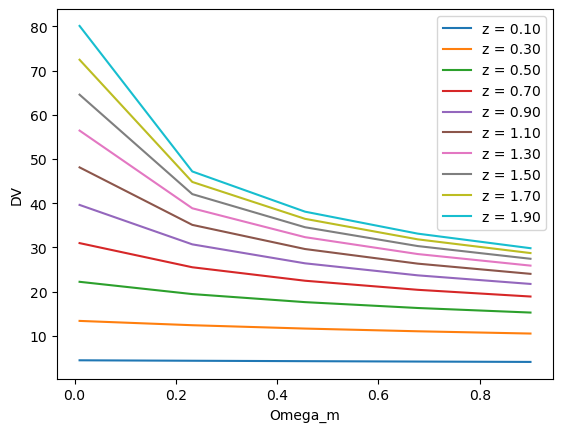

In [17]:
list_z,list_data_dv = [],[]
for data,m,c in zip(list_data,list_mean,list_covariance):
    z = data.attrs['zeff']
    # everything in Mpc/h
    dv = z**(1./3.) * ((1 + z)*cosmo_fid.angular_diameter_distance(z))**(2./3.) * (100. * cosmo_fid.efunc(z))**(-1./3.) / cosmo_fid.rs_drag
    list_z.append(z)
    list_data_dv.append((m*dv,c*dv**2))

print(cosmo_fid.rs_drag)
list_z = np.array(list_z)

from scipy import integrate, constants

def efunc(z, Omega_m=0.3, Omega_k=0.):
    Omega_lambda = 1 - Omega_m - Omega_k
    return np.sqrt(Omega_m*(1 + z)**3 + Omega_k*(1 + z)**2 + Omega_lambda)

def hubble(z, *args, **kwargs):
    return 100.*efunc(z,*args,**kwargs)

def comoving_angular_distance(z, Omega_m=0.3, Omega_k=0.):
    
    def fun(z):
        return 1./efunc(z,Omega_m=Omega_m,Omega_k=Omega_k)

    dc = integrate.quad(fun,0,z)[0]
    if Omega_k == 0:
        dm = dc
    elif Omega_k < 0:
        dm = np.sin((-Omega_k)**0.5 * dc)/(-Omega_k)**0.5
    else:
        dm = np.sinh(Omega_k**0.5 * dc)/Omega_k**0.5
    return constants.c/1e3/100.*dm

def spherically_averaged_distance(z, *args):
    return z**(1./3.) * comoving_angular_distance(z,*args)**(2./3.) * hubble(z,*args)**(-1./3.)

def model(rdrag, *args):
    return np.array([spherically_averaged_distance(z,*args) for z in list_z]) / rdrag

list_Omega_m = np.linspace(0.01,0.9,5)
"""
for Omega_m in list_Omega_m:
    plt.plot(list_z,[spherically_averaged_distance(z,Omega_m) for z in list_z],label='Omega_m = {:.2f}'.format(Omega_m))
plt.legend()
plt.show()
"""
for z in list_z:
    plt.plot(list_Omega_m,[spherically_averaged_distance(z,Omega_m) for Omega_m in list_Omega_m],label='z = {:.2f}'.format(z))
plt.legend()
plt.xlabel('Omega_m')
plt.ylabel('DV')
plt.show()

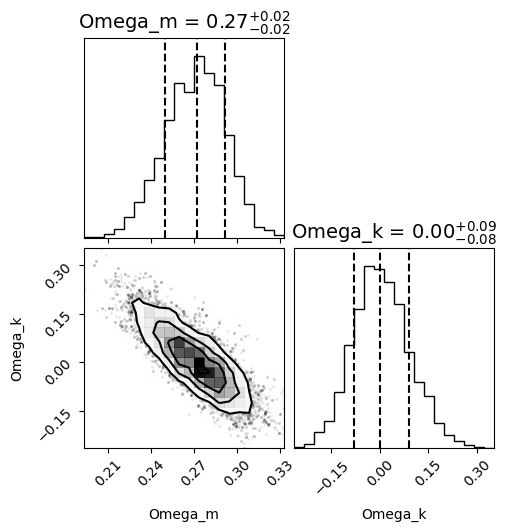

In [10]:
def chi2(args):
    list_model_dv = model(*args)
    toret = 0.
    for data_dv,model_dv in zip(list_data_dv,list_model_dv):
        toret += (data_dv[0] - model_dv)**2/data_dv[1]
    return toret

init = [100.,0.3,0.]
bounds = [(20,400),(0.01,0.9),(-0.8,0.8)]

def logprior(args):
    for x,b in zip(args,bounds):
        if not (x > b[0]) & (x < b[1]):
            return -np.inf
    return 0.

def logposterior(args):
    tmp = logprior(args)
    if not np.isfinite(tmp): return tmp
    return -1./2.*chi2(args) + tmp

ndim = len(init)
nwalkers = 4*ndim
nsteps = 2000
sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
sampler.run_mcmc(start,nsteps)
samples = sampler.get_chain(flat=True)
samples = samples[len(samples)//2:,1:]
labels = ['Omega_m','Omega_k']
#samples[:,1] = 1 - samples[:,0] - samples[:,1]
#labels = ['Omega_m','Omega_lambda']
fig = corner.corner(samples,labels=labels,quantiles=[0.16,0.5,0.84],show_titles=True,title_kwargs={'fontsize':14})
plt.show()

### Inverse distance ladder
Do the same, but for $r_{\mathrm{drag}}$ use a Gaussian prior $r_{\mathrm{drag}} = 149.47 \pm 0.48 \; \mathrm{Mpc}$.  
Assume zero curvature for this exercise (though you can let it free in general, in addition to different dark energy models --- all those are constrained by BAO).
Sample the likelihood and draw the contours $\Omega_{m} - H_{0}$.

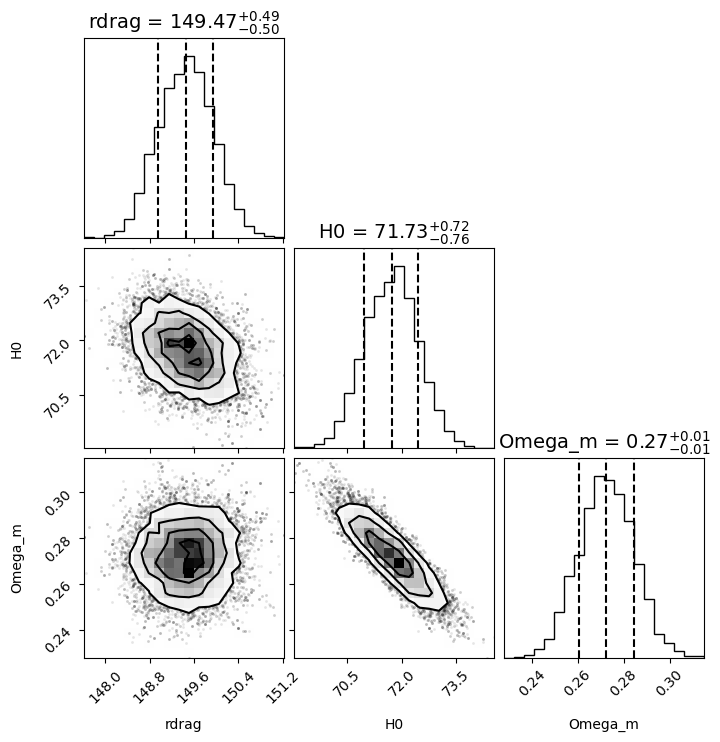

In [11]:
def model(rdrag, H0, *args):
    return np.array([spherically_averaged_distance(z,*args) for z in list_z]) / (H0/100.) / rdrag

init = [149.47,70,0.3]
bounds = [(100,200),(50,100),(0.1,0.5)]

def logprior(args):
    for x,b in zip(args,bounds):
        if not (x > b[0]) & (x < b[1]):
            return -np.inf
    rdrag = args[0]
    return -1./2.*(rdrag - 149.47)**2/0.48**2

def logposterior(args):
    tmp = logprior(args)
    if not np.isfinite(tmp): return tmp
    return -1./2.*chi2(args) + tmp

ndim = len(init)
nwalkers = 4*ndim
nsteps = 3000
sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
sampler.run_mcmc(start,nsteps)
samples = sampler.get_chain(flat=True)
samples = samples[len(samples)//2:]
labels = ['rdrag','H0','Omega_m','Omega_k']
fig = corner.corner(samples,labels=labels,quantiles=[0.16,0.5,0.84],show_titles=True,title_kwargs={'fontsize':14})
plt.show()

### BBN prior
CMB constraints provide a measurement of $r_{\mathrm{drag}}$ (through $\omega_{cdm}$ and $\omega_{b}$),
but we only need $\omega_{b} = \Omega_{b} h^{2}$ since $\Omega_{m}$ is constrained by BAO mesurements.  
$\omega_{b} = \Omega_{b} h^{2}$ is constrained by measurements of deuterium abundance as a result of BBN.
Implement $r_{\mathrm{drag}}$, following https://arxiv.org/abs/astro-ph/9709112, eq. 4 - 6.
For $z_{\mathrm{drag}}$, rather use https://arxiv.org/abs/astro-ph/9510117, eq. E1 (found better match to Boltzmann code).
Fix $T_\mathrm{cmb} = 2.7255$ (Cobe-FIRAS).  
Redo the previous sampling, varying $H_{0}$, $\Omega_{m}$ and $\omega_{b}$ with the BBN prior: $\omega_{b} = 0.02235 \pm 0.00037$.

In [12]:
def rs_drag(omega_b, omega_m):
    T_cmb = 2.7255
    frac_baryon  = omega_b / omega_m
    theta_cmb = T_cmb / 2.7

    # redshift and wavenumber of equality
    # EH eq. 2 & 3
    z_eq = 2.5e4 * omega_m * theta_cmb ** (-4) - 1. # this is z
    k_eq = 0.0746 * omega_m * theta_cmb ** (-2) # units of 1/Mpc

    # sound horizon and k_silk
    # EH eq. 4
    z_drag_b1 = 0.313 * omega_m ** (-0.419) * (1 + 0.607 * omega_m ** 0.674)
    z_drag_b2 = 0.238 * omega_m ** 0.223
    #z_drag = 1291 * omega_m ** 0.251 / (1. + 0.659 * omega_m ** 0.828) * (1. + z_drag_b1 * omega_b ** z_drag_b2)
    # HS1996, arXiv 9510117, eq. E1 actually better match to CLASS
    z_drag = 1345 * omega_m ** 0.251 / (1. + 0.659 * omega_m ** 0.828) * (1. + z_drag_b1 * omega_b ** z_drag_b2)

    # EH eq. 5
    r_drag = 31.5 * omega_b * theta_cmb ** (-4) * (1000. / (1 + z_drag))
    r_eq   = 31.5 * omega_b * theta_cmb ** (-4) * (1000. / (1 + z_eq))

    # EH eq. 6
    rs_drag = 2. / (3.*k_eq) * np.sqrt(6. / r_eq) * \
                np.log((np.sqrt(1 + r_drag) + np.sqrt(r_drag + r_eq)) / (1 + np.sqrt(r_eq)))
    return rs_drag

#mega_b = cosmo_fid.Omega0_b*cosmo_fid.h**2
#omega_m = cosmo_fid.Omega0_m*cosmo_fid.h**2
#print(rs_drag(omega_b,omega_m),cosmo_fid.rs_drag/cosmo_fid.h)

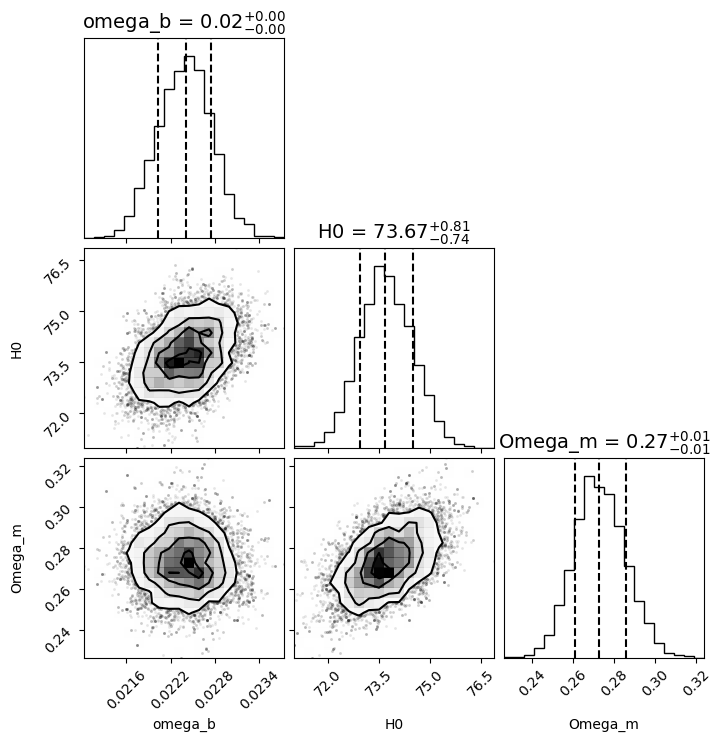

In [13]:
def model(omega_b, H0, Omega_m):
    h = H0/100.
    rdrag = rs_drag(omega_b, Omega_m*h**2)
    return np.array([spherically_averaged_distance(z,Omega_m) for z in list_z]) / h / rdrag

init = [0.02235,70,0.3]
bounds = [(0.01,0.03),(50,100),(0.1,0.5)]

def logprior(args):
    for x,b in zip(args,bounds):
        if not (x > b[0]) & (x < b[1]):
            return -np.inf
    omega_b = args[0]
    return -1./2.*(omega_b - 0.02235)**2/0.00037**2

def logposterior(args):
    tmp = logprior(args)
    if not np.isfinite(tmp): return tmp
    return -1./2.*chi2(args) + tmp

def chi2(args):
    list_model_dv = model(*args)
    toret = 0.
    for z,data_dv,model_dv in zip(list_z,list_data_dv,list_model_dv):
        toret += (data_dv[0] - model_dv)**2/data_dv[1]
    return toret

ndim = len(init)
nwalkers = 4*ndim
nsteps = 3000
sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
sampler.run_mcmc(start,nsteps)
samples = sampler.get_chain(flat=True)
samples = samples[len(samples)//2:]
labels = ['omega_b','H0','Omega_m']
fig = corner.corner(samples,labels=labels,quantiles=[0.16,0.5,0.84],show_titles=True,title_kwargs={'fontsize':14})
plt.show()

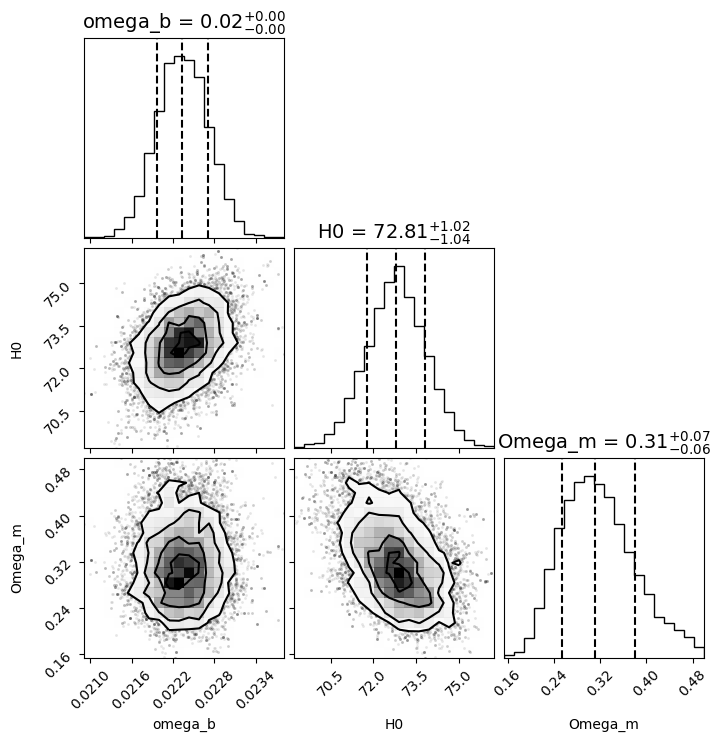

In [14]:
def model(omega_b, H0, Omega_m):
    h = H0/100.
    rdrag = rs_drag(omega_b, Omega_m*h**2)
    return np.array([spherically_averaged_distance(z,Omega_m) for z in list_z]) / h / rdrag

init = [0.02235,70,0.3]
bounds = [(0.01,0.03),(50,100),(0.1,0.5)]

def chi2(args):
    list_model_dv = model(*args)
    toret = 0.
    for z,data_dv,model_dv in zip(list_z,list_data_dv,list_model_dv):
        if z > 1.0:
            toret += (data_dv[0] - model_dv)**2/data_dv[1]
    return toret

sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
sampler.run_mcmc(start,nsteps)
samples = sampler.get_chain(flat=True)
samples = samples[len(samples)//2:]
labels = ['omega_b','H0','Omega_m']
fig = corner.corner(samples,labels=labels,quantiles=[0.16,0.5,0.84],show_titles=True,title_kwargs={'fontsize':14})
plt.show()

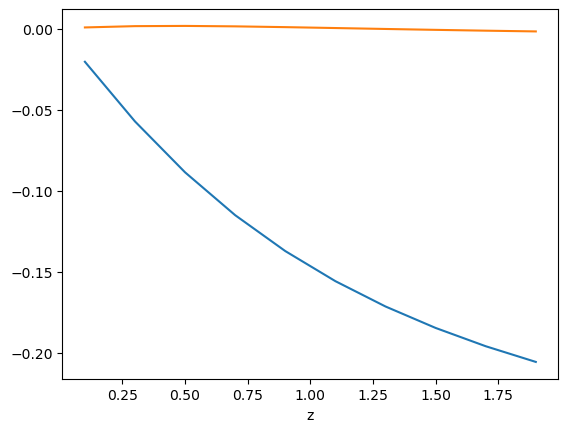

[[5.16759716e+05 1.05090252e+04]
 [1.05090252e+04 2.73082984e+02]]
[[70087.78329789 -3037.44122018]
 [-3037.44122018   225.15645261]]


In [15]:
def get_deriv(i=1,dx=1e-3):
    xp,xm = init.copy(),init.copy()
    xp[i] += dx
    xm[i] -= dx 
    return (model(*xp) - model(*xm))/(2*dx)

deriv_H0 = get_deriv(1)
deriv_Omega_m = get_deriv(2)
plt.plot(list_z,deriv_H0*init[1])
plt.plot(list_z,deriv_Omega_m*init[0])
plt.xlabel('z')
plt.show()

deriv_model = np.array([deriv_H0,deriv_Omega_m])[:,list_z<1]
invfisher = deriv_model.dot(deriv_model.T)
print(np.linalg.inv(invfisher))

deriv_model = np.array([deriv_H0,deriv_Omega_m])[:,list_z>1]
invfisher = deriv_model.dot(deriv_model.T)
print(np.linalg.inv(invfisher))

### Bonus, work with real data!
Follow instructions in eBOSS_LRGpCMASS.ipynb